In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import itertools

import healpy as hp
import pymaster as nmt

import cov_utils as cu
import cl_utils as clu
import anglib as al
import loading as load


In [2]:
def compute_cov(Cl, keys, keys_all, workspace, cov_workspace):
    nell = Cl['ell'].size
    ncl = len(keys)
    print(ncl*nell)
    covmat = np.zeros((ncl*nell, ncl*nell))

    for key in keys_all:
        probeA, probeB = key.split('-')
        Cl['-'.join([probeB, probeA])] = Cl[key]

    for (idx1, key1), (idx2, key2) in itertools.combinations_with_replacement(enumerate(keys), 2):
        print(key1, key2, flush=True)
        probeA, probeB = key1.split('-')
        probeC, probeD = key2.split('-')

        covmat[idx1*nell:(idx1+1)*nell, idx2*nell:(idx2+1)*nell] =\
            nmt.gaussian_covariance(cov_workspace, 0, 0, 0, 0,
                                    [Cl['-'.join([probeA, probeC])]],
                                    [Cl['-'.join([probeB, probeC])]],
                                    [Cl['-'.join([probeA, probeD])]],
                                    [Cl['-'.join([probeB, probeD])]],
                                    workspace, wb=workspace)

In [3]:
data_ref = '/home/hidra2/gouyou/euclid/nl_bias_flagship/data/'

## Get / Generate Masks

In [4]:
nside = 256

mask_fullsky = hp.read_map(data_ref+'mask/fullsky_mask_binary_NS256.fits')
fmask_fullsky = nmt.NmtField(mask_fullsky, [mask_fullsky])

mask_flagship = hp.read_map(data_ref+'mask/flagship2_mask_binary_NS256.fits')
fmask_flagship = nmt.NmtField(mask_flagship, [mask_flagship])

## Get Cl's

In [6]:
ref = '/home/hidra2/gouyou/cosmosis-standard-library/working_dir/output/fs2_nlbias/simulation/fs2_firstchain_linbias_unbinned/'
nzbins = 6
npairs_GC = int(nzbins*(nzbins-1)/2 + nzbins)
npairs_GGL = int(nzbins*nzbins)

cls_gc_auto, keys_gc_auto = load.get_cosmosis_Cl(ref, nzbins, 'GC', False)
cls_gc, keys_gc = load.get_cosmosis_Cl(ref, nzbins, 'GC', True)
cls_wl, keys_wl = load.get_cosmosis_Cl(ref, nzbins, 'WL', True)
cls_ggl, keys_ggl = load.get_cosmosis_Cl(ref, nzbins, 'GGL', True)

ell_ub = cls_gc_auto['ell']
nell_ub = ell_ub.size


## Initiate binning 

In [49]:
lmin = 10
bw_lin = 50
nbl_log = 11

bnmt_lin = al.edges_binning(nside, lmin, bw_lin)
bnmt_log = al.edges_log_binning(nside, lmin, nbl_log)
bnmt_log_ns8 = al.edges_log_binning(8, lmin, 5)
bnmt_lin_ns8 = al.edges_binning(NSIDE=8, lmin=10, bw=5)


print('ell_lin = {}'.format(bnmt_lin.get_effective_ells().size))
print('ell_log = {}'.format(bnmt_log.get_effective_ells().size))
print('ell_log nside8 = {}'.format(bnmt_lin_ns8.get_effective_ells()))

nbl_log = bnmt_log.get_effective_ells().size

ell_lin = 11
ell_log = 10
ell_log nside8 = [12. 17.]


## Compute workspace and mixing matrix

In [16]:
wksp_flagship_linbin = al.coupling_matrix(bnmt_lin, mask_flagship,
                    data_ref+'nmt_workspace/FS2_2pt_NmtWorkspace_NS256_LIN_LMIN10_BW50.fits')
wksp_flagship_logbin = al.coupling_matrix(bnmt_log, mask_flagship,
                    data_ref+'nmt_workspace/FS2_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits')

wksp_fullsky_linbin = al.coupling_matrix(bnmt_lin, mask_fullsky,
                    data_ref+'nmt_workspace/fullsky_2pt_NmtWorkspace_NS256_LIN_LMIN10_BW50.fits')
wksp_fullsky_logbin = al.coupling_matrix(bnmt_log, mask_fullsky,
                    data_ref+'nmt_workspace/fullsky_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits')

Compute the mixing matrix
Mixing matrix has already been calculated and is in the workspace file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/FS2_2pt_NmtWorkspace_NS256_LIN_LMIN10_BW50.fits . Read it.
Done computing the mixing matrix. It took  0.12516379356384277 s.
Compute the mixing matrix
Mixing matrix has already been calculated and is in the workspace file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/FS2_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits . Read it.
Done computing the mixing matrix. It took  0.08110642433166504 s.
Compute the mixing matrix
Mixing matrix has already been calculated and is in the workspace file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/fullsky_2pt_NmtWorkspace_NS256_LIN_LMIN10_BW50.fits . Read it.
Done computing the mixing matrix. It took  0.08324861526489258 s.
Compute the mixing matrix
Mixing matrix has already been calculated and is in the workspace file :  /home/hidra2/gouyou/euclid/nl_b

In [19]:
cov_wksp_flagship_linbin = nmt.NmtCovarianceWorkspace()
cov_wksp_flagship_logbin = nmt.NmtCovarianceWorkspace()
cov_wksp_fullsky_linbin = nmt.NmtCovarianceWorkspace()
cov_wksp_fullsky_logbin = nmt.NmtCovarianceWorkspace()

cov_wksp_flagship_linbin.compute_coupling_coefficients(fmask_flagship, fmask_flagship)
cov_wksp_fullsky_linbin.compute_coupling_coefficients(fmask_fullsky, fmask_fullsky)


## Get/Compute covariance

In [37]:
ref_cov = '/home/hidra2/gouyou/euclid/nl_bias_flagship/data/covariance/'

In [9]:
# Reference case
cov_fs2_full3x2_log = np.load(ref_cov+'nmt_test_NS256_fs2_full3x2_logbin.npy')
cov_fsky_full3x2_log = np.load(ref_cov+'nmt_test_NS256_fsky_full3x2_logbin.npy')


In [ ]:
cu.pos_def(cov_fs2_full3x2_log, 'FS2, full 3x2pt, log binning')
cu.pos_def(cov_fsky_full3x2_log, 'fullsky, full 3x2pt, log binning')


FS2, full 3x2pt, log binning  is NOT positive definite
fullsky, full 3x2pt, log binning  is positive definite


### Varying ell binning

In [10]:
cov_fs2_full3x2_lin = np.load(ref_cov+'nmt_test_NS256_fs2_full3x2_linbin.npy')
cov_fsky_full3x2_lin = np.load(ref_cov+'nmt_test_NS256_fsky_full3x2_linbin.npy')


In [ ]:
cu.pos_def(cov_fs2_full3x2_lin, 'FS2, full 3x2pt, Linear binning')
cu.pos_def(cov_fsky_full3x2_lin, 'fullsky, full 3x2pt, Linear binning')

FS2, full 3x2pt, Linear binning  is NOT positive definite
fullsky, full 3x2pt, Linear binning  is positive definite


### Varying probes

In [36]:
cov_fs2_GC_log = np.load(ref_cov+'nmt_test_NS256_fs2_fullGC_logbin.npy')
cov_fs2_autoGC_log = np.load(ref_cov+'nmt_test_NS256_fs2_autoGC_logbin.npy')
cov_fsky_GC_log = np.load(ref_cov+'nmt_test_NS256_fsky_fullGC_logbin.npy')
cov_fsky_autoGC_log = np.load(ref_cov+'nmt_test_NS256_fsky_autoGC_logbin.npy')

cov_fs2_WL_log = np.load(ref_cov+'nmt_test_NS256_fs2_fullWL_logbin.npy')
cov_fs2_autoWL_log = np.load(ref_cov+'nmt_test_NS256_fs2_autoWL_logbin.npy')


cov_fs2_GC_log_select = cov_fs2_full3x2_log[:npairs_GC*nbl_log, :npairs_GC*nbl_log]

In [ ]:
cu.pos_def(cov_fs2_GC_log, 'FS2, full GC, Log binning')
cu.pos_def(cov_fs2_autoGC_log, 'FS2, auto-GC, Log binning')
cu.pos_def(cov_fsky_GC_log, 'fullsky, full GC, Log binning')
cu.pos_def(cov_fsky_autoGC_log, 'fullsky, auto-GC, Log binning')

cu.pos_def(cov_fs2_WL_log, 'FS2, full WL, Log binning')
cu.pos_def(cov_fs2_autoWL_log, 'FS2, auto-WL, Log binning')

cu.pos_def(cov_fs2_GC_log_select, 'FS2, full GC, Log binning, selected from the full3x2pt')


FS2, full GC, Log binning  is positive definite
FS2, auto-GC, Log binning  is positive definite
fullsky, full GC, Log binning  is positive definite
fullsky, auto-GC, Log binning  is positive definite
FS2, full WL, Log binning  is NOT positive definite
FS2, auto-WL, Log binning  is NOT positive definite
FS2, full GC, Log binning, selected from the full3x2pt  is positive definite


### Varying size of matrix

In [39]:
# SSC paper setting and Euclid DR3 mask
cov_SSC_paper = np.load('../Spaceborne_covg/output/cov_Gauss_3x2pt_2D_probe_zpair_ell_SSCpaper_partsky.npy')
print(cov_SSC_paper.shape)

nz_SSC = 10
jump = int((nz_SSC*(nz_SSC-1)/2 + nz_SSC)*34 + nz_SSC*nz_SSC*34)
cov_SSC_paper_GC = cov_SSC_paper[jump:, jump:]
cov_SSC_paper_GC_reduced = cov_SSC_paper[jump:jump+21*34, jump:jump+21*34]
print(cov_SSC_paper_GC_reduced.shape)

# plt.figure()
# plt.semilogy(np.diag(cov_SSC_paper))
# plt.semilogy(np.diag(cov_SSC_paper_GC))
# plt.semilogy(np.diag(cov_SSC_paper_GC_reduced))

# plt.show()

cov_SSC_paper_GC_re = np.load(ref_cov+'nmt_test_NS256_SSCpaper_GC_logbin.npy')
cov_SSC_paper_GCauto_re = np.load(ref_cov+'nmt_test_NS256_SSCpaper_GCauto_logbin.npy')
cov_SSC_paper_3x2_re = np.load(ref_cov+'nmt_test_NS256_SSCpaper_3x2_logbin.npy')


(7140, 7140)
(714, 714)


In [ ]:
cu.pos_def(cov_SSC_paper, 'SSC paper')
cu.pos_def(cov_SSC_paper_GC, 'SSC paper GC')
cu.pos_def(cov_SSC_paper_GC_reduced, 'SSC paper GC reduced')


cu.pos_def(cov_SSC_paper_3x2_re, 'SSC paper with NS256 FS2 mask, 3x2')
cu.pos_def(cov_SSC_paper_GC_re, 'SSC paper with NS256 FS2 mask, GC')
cu.pos_def(cov_SSC_paper_GCauto_re, 'SSC paper with NS256 FS2 mask, GC auto')




SSC paper  is NOT positive definite
SSC paper GC  is NOT positive definite
SSC paper GC reduced  is NOT positive definite
SSC paper with NS256 FS2 mask, 3x2  is NOT positive definite
SSC paper with NS256 FS2 mask, GC  is NOT positive definite
SSC paper with NS256 FS2 mask, GC auto  is positive definite


### Varying apodization 

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


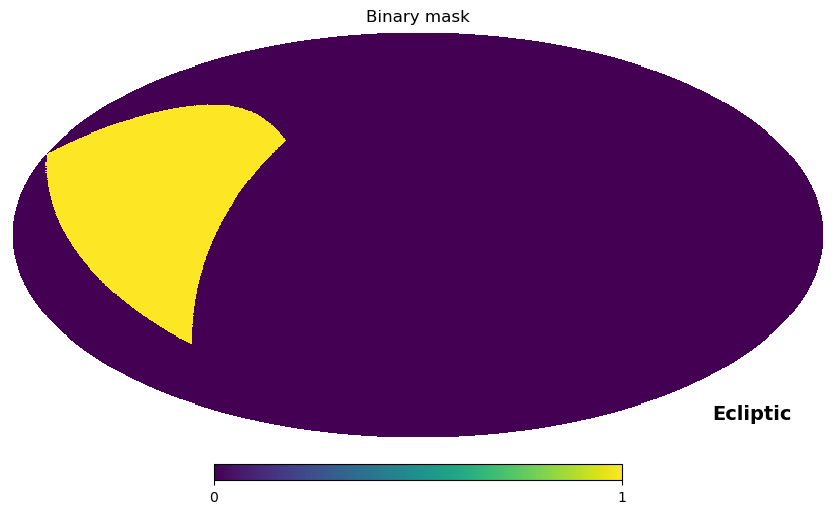

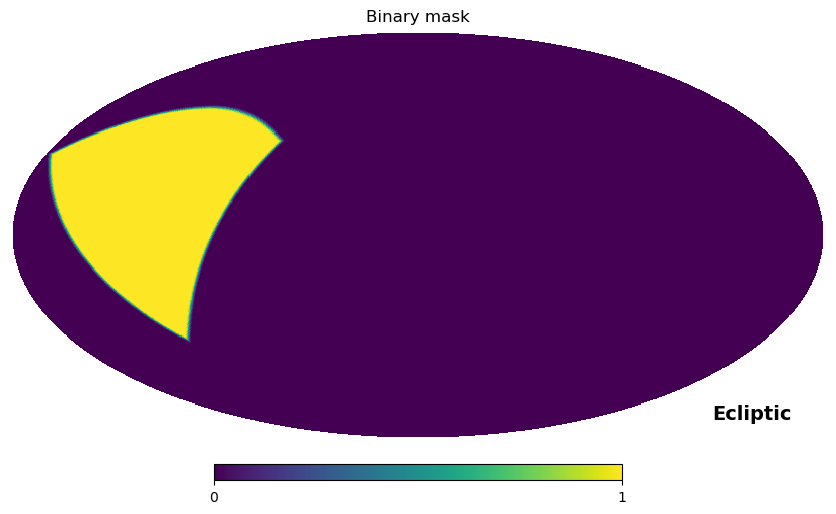

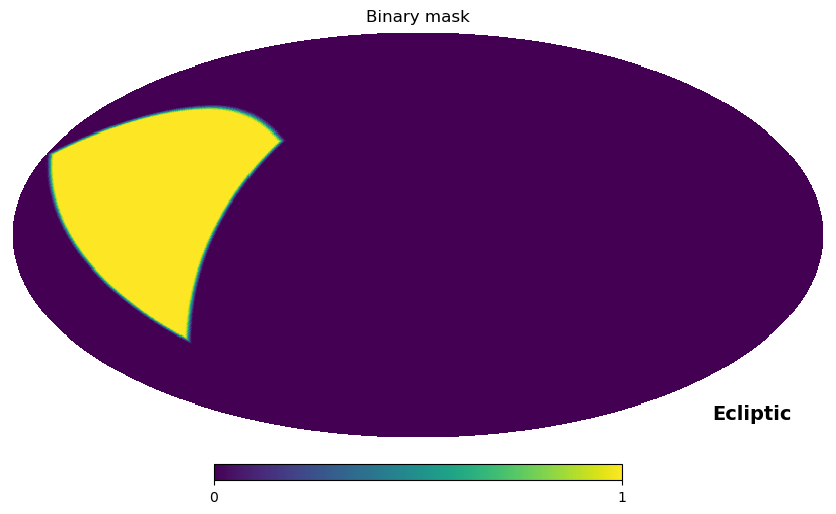

In [20]:
aposcale = 2.5
mask_flagship_C1 = nmt.mask_apodization(mask_flagship, aposcale, apotype="C1")
mask_flagship_C2 = nmt.mask_apodization(mask_flagship, aposcale, apotype="C2")

hp.write_map('/home/hidra2/gouyou/euclid/nl_bias_flagship/data/mask/flagship2_mask_C1_binary_NS256.fits',
             mask_flagship_C1, overwrite=True)
hp.write_map('/home/hidra2/gouyou/euclid/nl_bias_flagship/data/mask/flagship2_mask_C2_binary_NS256.fits',
             mask_flagship_C2, overwrite=True)

hp.mollview(mask_flagship, title='Binary mask', coord=['G', 'E'])
hp.mollview(mask_flagship_C1, title='Binary mask', coord=['G', 'E'])
hp.mollview(mask_flagship_C2, title='Binary mask', coord=['G', 'E'])
plt.show()




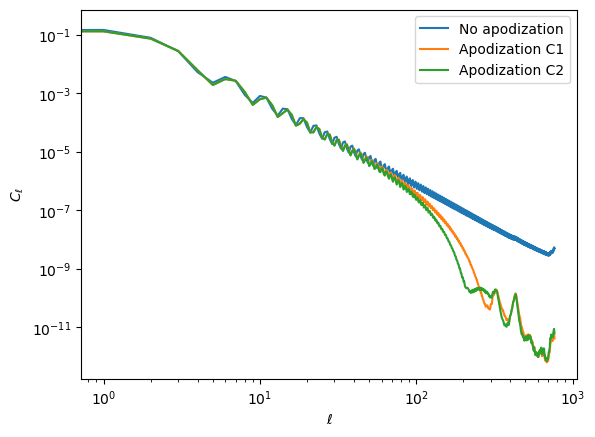

In [19]:
cl_mask_flagship = hp.anafast(mask_flagship)
cl_mask_flagship_C1 = hp.anafast(mask_flagship_C1)
cl_mask_flagship_C2 = hp.anafast(mask_flagship_C2)

plt.figure()
plt.loglog(cl_mask_flagship, label='No apodization')
plt.loglog(cl_mask_flagship_C1, label='Apodization C1')
plt.loglog(cl_mask_flagship_C2, label='Apodization C2')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()
plt.show()

In [64]:
wksp_flagship_C1_logbin = al.coupling_matrix(bnmt_log, mask_flagship_C1,
                    data_ref+'nmt_workspace/FS2_C1_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits')

wksp_flagship_C2_logbin = al.coupling_matrix(bnmt_log, mask_flagship_C1,
                    data_ref+'nmt_workspace/FS2_C2_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits')

Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/FS2_C1_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits  does not exists. Calculating the mixing matrix and writing it.
Done computing the mixing matrix. It took  0.19096899032592773 s.
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/FS2_C2_2pt_NmtWorkspace_NS256_LOG_LMIN10_NBL11.fits  does not exists. Calculating the mixing matrix and writing it.
Done computing the mixing matrix. It took  0.15796208381652832 s.


In [73]:
cov_fs2_C1_full3x2_log = np.load(ref_cov+'nmt_test_NS256_fs2_C1_full3x2_logbin.npy')
cov_fs2_C2_full3x2_log = np.load(ref_cov+'nmt_test_NS256_fs2_C2_full3x2_logbin.npy')

cov_fs2_C1_GC_log = np.load(ref_cov+'nmt_test_NS256_fs2_C1_GC_logbin.npy')
cov_fs2_C2_GC_log = np.load(ref_cov+'nmt_test_NS256_fs2_C2_GC_logbin.npy')

cov_fs2_WL_log = np.load(ref_cov+'nmt_test_NS256_fs2_fullWL_logbin.npy')
cov_fs2_C1_WL_log = np.load(ref_cov+'nmt_test_NS256_fs2_C1_WL_logbin.npy')


cu.pos_def(cov_fs2_C1_full3x2_log, 'FS2 C1 apodization, full 3x2pt, log binning')
cu.pos_def(cov_fs2_C2_full3x2_log, 'FS2 C2 apodization, full 3x2pt, log binning')

cu.pos_def(cov_fs2_C1_GC_log, 'FS2 C1 apodization, full GC, log binning')
cu.pos_def(cov_fs2_C2_GC_log, 'FS2 C2 apodization, full GC, log binning')

cu.pos_def(cov_fs2_WL_log, 'FS2 , full WL, log binning')
cu.pos_def(cov_fs2_C1_WL_log, 'FS2 C1 apodization, full WL, log binning')

FS2 C1 apodization, full 3x2pt, log binning  is NOT positive definite
FS2 C2 apodization, full 3x2pt, log binning  is NOT positive definite
FS2 C1 apodization, full GC, log binning  is positive definite
FS2 C2 apodization, full GC, log binning  is positive definite
FS2 , full WL, log binning  is NOT positive definite
FS2 C1 apodization, full WL, log binning  is NOT positive definite


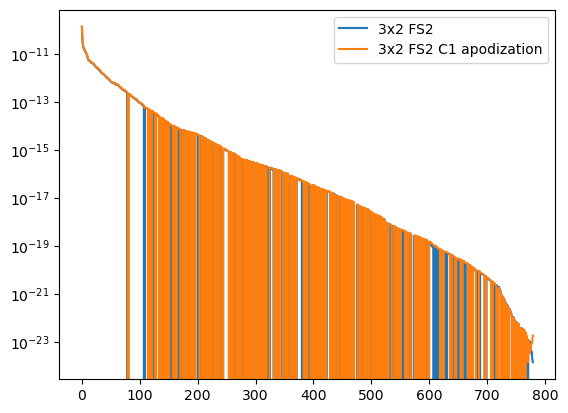

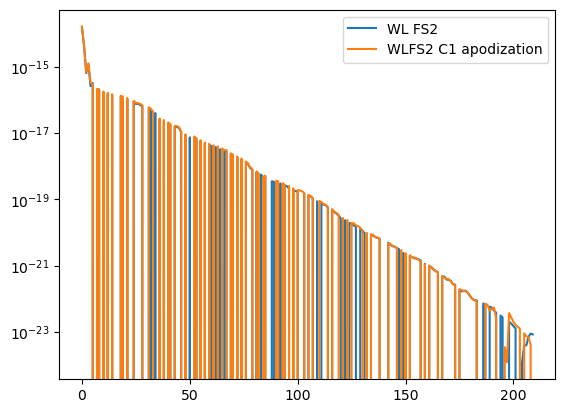

In [74]:
eigv_fs2_full3x2_log = np.linalg.eig(cov_fs2_full3x2_log)[0]
eigv_fs2_C1_full3x2_log = np.linalg.eig(cov_fs2_C1_full3x2_log)[0]

eigv_fs2_WL_log = np.linalg.eig(cov_fs2_WL_log)[0]
eigv_fs2_C1_WL_log = np.linalg.eig(cov_fs2_C1_WL_log)[0]


plt.figure()
plt.semilogy(eigv_fs2_full3x2_log, label='3x2 FS2')
plt.semilogy(eigv_fs2_C1_full3x2_log, label='3x2 FS2 C1 apodization')
plt.legend()
plt.show()

plt.figure()
plt.semilogy(eigv_fs2_WL_log, label='WL FS2')
plt.semilogy(eigv_fs2_C1_WL_log, label='WLFS2 C1 apodization')
plt.legend()
plt.show()

### With white noise Cl's

Generate white noise Cl's. Constant mean value of each Cl 

In [59]:
ref_wn = '/home/hidra2/gouyou/euclid/cov_3x2/inputs/white_noise_cl/'

#GC and WL
for i in range(nzbins):
    for j in range(i, nzbins):
        gc_tosave = np.full(3072, np.mean(cls_gc['D{}-D{}'.format(i,j)]))
        wl_tosave = np.full(3072, np.mean(cls_wl['G{}-G{}'.format(i,j)]))
        np.savetxt(ref_wn+'galaxy_cl/bin_{}_{}.txt'.format(j+1,i+1), gc_tosave)
        np.savetxt(ref_wn+'shear_cl/bin_{}_{}.txt'.format(j+1,i+1), wl_tosave)

# GGL
for i in range(nzbins):
    for j in range(nzbins):
        ggl_tosave = np.full(3072, np.mean(cls_ggl['D{}-G{}'.format(i,j)]))
        np.savetxt(ref_wn+'galaxy_shear_cl/bin_{}_{}.txt'.format(j+1,i+1), ggl_tosave)

cls_gc_auto_wn, keys_gc_auto = load.get_cosmosis_Cl(ref_wn, nzbins, 'GC', False)
cls_gc_wn, keys_gc = load.get_cosmosis_Cl(ref_wn, nzbins, 'GC', True)
cls_wl_wn, keys_wl = load.get_cosmosis_Cl(ref_wn, nzbins, 'WL', True)
cls_ggl_wn, keys_ggl = load.get_cosmosis_Cl(ref_wn, nzbins, 'GGL', True)

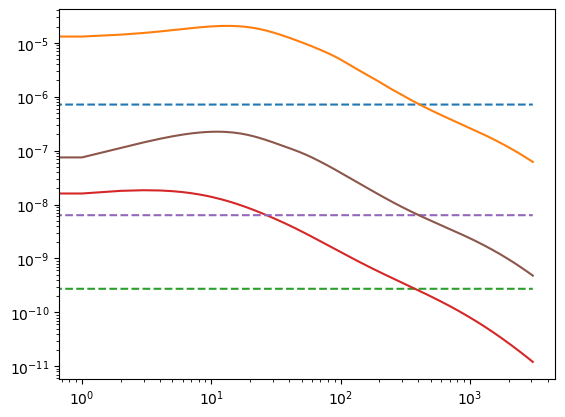

In [61]:
plt.figure()
plt.loglog(ell_ub, cls_gc_wn['D0-D0'], ls='--')
plt.loglog(ell_ub, cls_gc['D0-D0'])

plt.loglog(ell_ub, cls_wl_wn['G0-G0'], ls='--')
plt.loglog(ell_ub, cls_wl['G0-G0'])

plt.loglog(ell_ub, cls_ggl_wn['D0-G0'], ls='--')
plt.loglog(ell_ub, cls_ggl['D0-G0'])
plt.show()

In [56]:
cov_fs2_full3x2_whitenoise_log = np.load(ref_cov+'nmt_test_NS256_whitenoise_full3x2_logbin.npy')
cov_fs2_GC_whitenoise_log = np.load(ref_cov+'nmt_test_NS256_whitenoise_GC_logbin.npy')
cov_fs2_WL_whitenoise_log = np.load(ref_cov+'nmt_test_NS256_whitenoise_WL_logbin.npy')


In [ ]:
cu.pos_def(cov_fs2_full3x2_whitenoise_log, 'FS2, 6 bins White noise Cl, full 3x2')
cu.pos_def(cov_fs2_GC_whitenoise_log, 'FS2, 6 bins White noise Cl, GC')
cu.pos_def(cov_fs2_WL_whitenoise_log, 'FS2, 6 bins White noise Cl, WL')


FS2, 6 bins White noise Cl, full 3x2  is NOT positive definite
FS2, 6 bins White noise Cl, GC  is NOT positive definite
FS2, 6 bins White noise Cl, WL  is positive definite


### Varying sky fraction

setting the output map dtype to [dtype('float64')]


0.125
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.125_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.


setting the output map dtype to [dtype('float64')]


Done computing the mixing matrix. It took  0.5077862739562988 s.
0.20052083333333334
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.2_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.


setting the output map dtype to [dtype('float64')]


Done computing the mixing matrix. It took  0.5155062675476074 s.
0.3997395833333333
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.4_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.


setting the output map dtype to [dtype('float64')]


Done computing the mixing matrix. It took  0.49144935607910156 s.
0.6002604166666666
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.6_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.


setting the output map dtype to [dtype('float64')]


Done computing the mixing matrix. It took  0.5145714282989502 s.
0.7994791666666666
Compute the mixing matrix


setting the output map dtype to [dtype('float64')]


The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.8_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.
Done computing the mixing matrix. It took  0.5158889293670654 s.
1.0
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky1_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.
Done computing the mixing matrix. It took  0.5030615329742432 s.


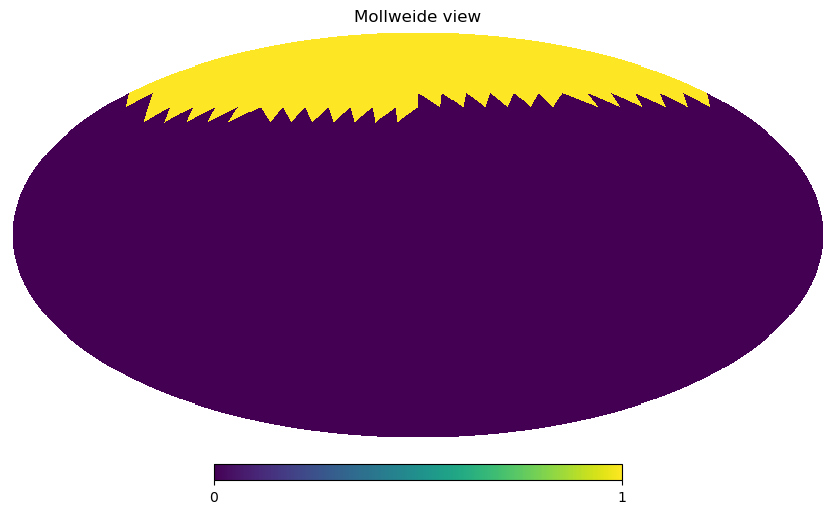

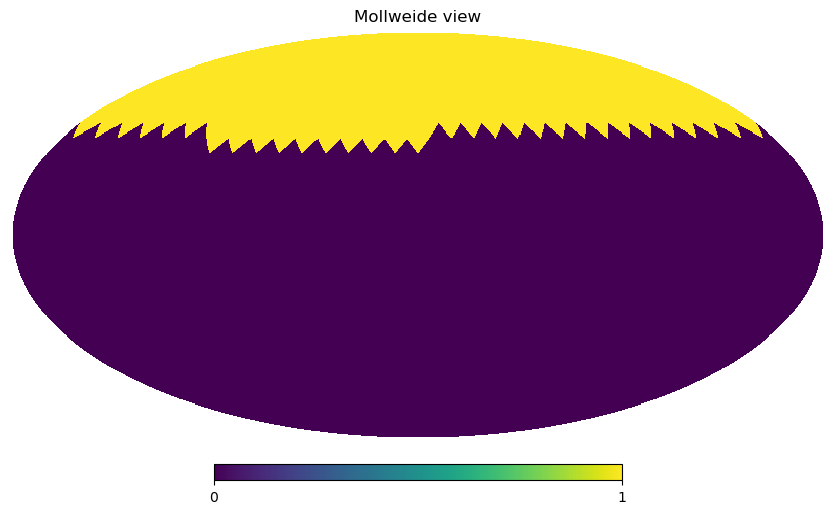

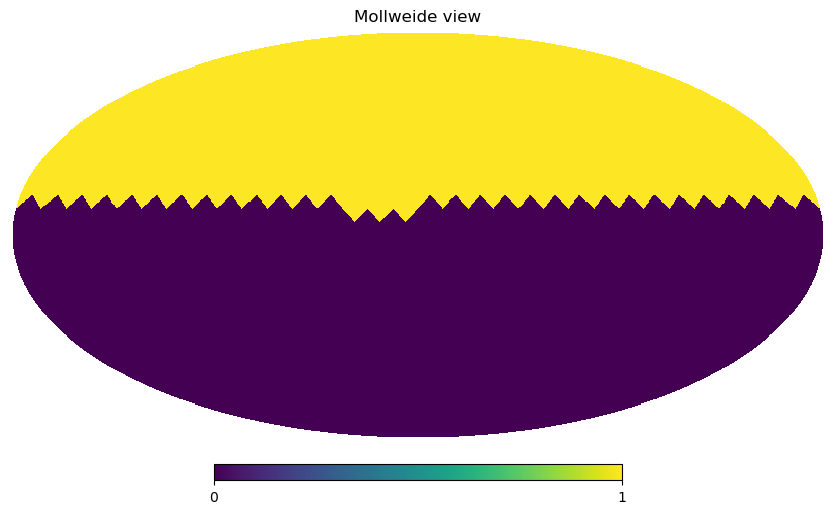

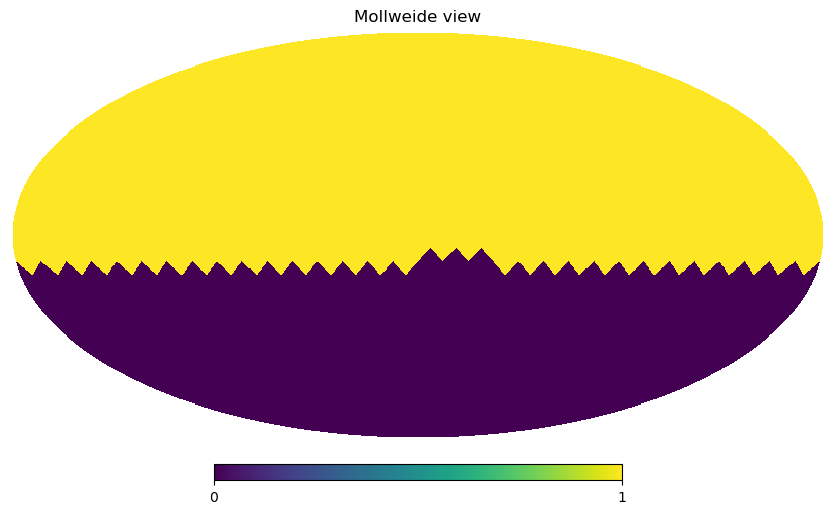

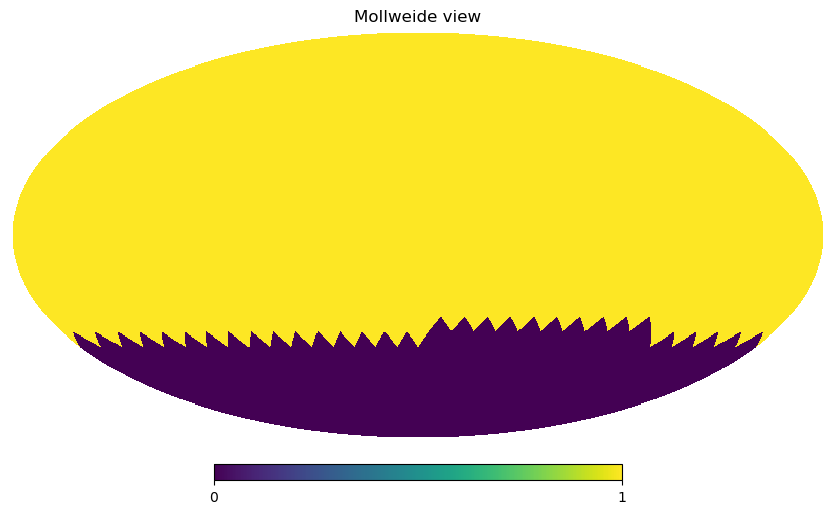

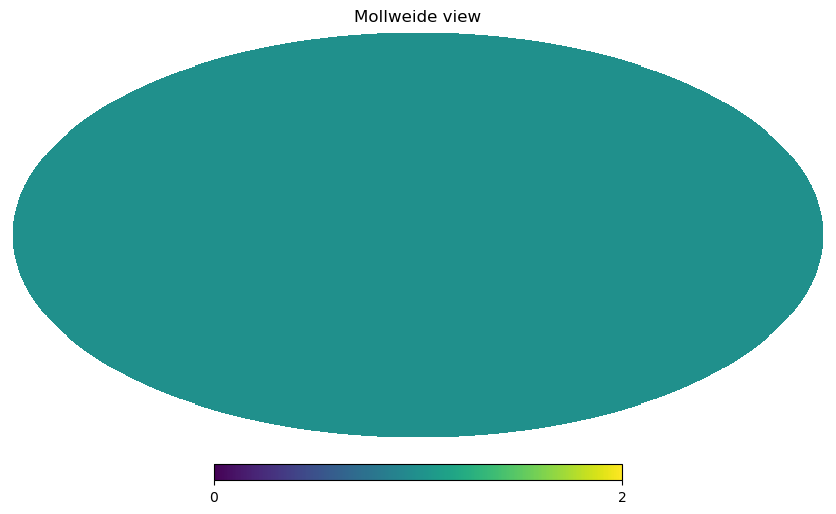

In [50]:
fsky = [0.125, 0.2, 0.4, 0.6, 0.8, 1]
for fs in fsky:
    map = np.zeros(hp.nside2npix(8))
    map[:round(map.size*fs)] = 1
    print(np.mean(map))
    hp.mollview(map)
    hp.write_map(data_ref+'mask/circle_fsky{}_NS8.fits'.format(fs), map, overwrite=True)
    wksp_fsky = al.coupling_matrix(bnmt_lin_ns8, map,
                    data_ref+'nmt_workspace/circle_fsky{}_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits'.format(fs))



setting the output map dtype to [dtype('float64')]


0.7604166666666666
Compute the mixing matrix
The file :  /home/hidra2/gouyou/euclid/nl_bias_flagship/data/nmt_workspace/circle_fsky0.7604166666666666_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits  does not exists. Calculating the mixing matrix and writing it.
Done computing the mixing matrix. It took  0.5239865779876709 s.


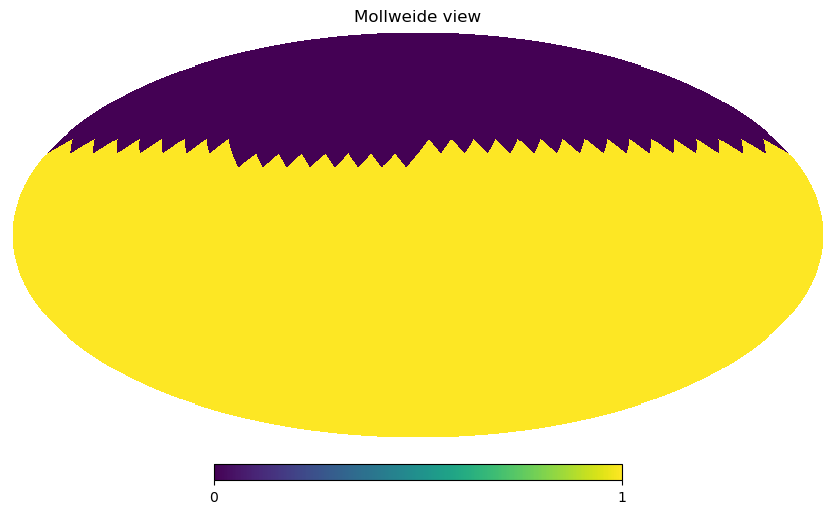

In [52]:
map = np.ones(hp.nside2npix(8))
map[:int(map.size/2)-200] = 0
print(np.mean(map))
hp.mollview(map)
hp.write_map(data_ref+'mask/circle_fsky{}_NS8.fits'.format(np.mean(map)), map, overwrite=True)
wksp_fsky = al.coupling_matrix(bnmt_lin_ns8, map,
                data_ref+'nmt_workspace/circle_fsky{}_NmtWorkspace_NS8_LIN_LMIN10_BW5.fits'.format(np.mean(map)))

NSIDE = 256 log binning

In [44]:
cov_circle_0125_full3x2_log = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.125_full3x2_logbin.npy')
cov_circle_02_full3x2_log = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.2_full3x2_logbin.npy')
cov_circle_04_full3x2_log = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.4_full3x2_logbin.npy')
cov_circle_06_full3x2_log = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.6_full3x2_logbin.npy')
cov_circle_08_full3x2_log = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.8_full3x2_logbin.npy')

cu.pos_def(cov_circle_0125_full3x2_log, 'Circle fsky=0.125, full 3x2pt, log binning')
cu.pos_def(cov_circle_02_full3x2_log, 'Circle fsky=0.2, full 3x2pt, log binning')
cu.pos_def(cov_circle_04_full3x2_log, 'Circle fsky=0.4, full 3x2pt, log binning')
cu.pos_def(cov_circle_06_full3x2_log, 'Circle fsky=0.6, full 3x2pt, log binning')
cu.pos_def(cov_circle_08_full3x2_log, 'Circle fsky=0.8, full 3x2pt, log binning')


Circle fsky=0.125, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.2, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.4, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.6, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.8, full 3x2pt, log binning  is NOT positive definite


NSIDE = 8 log binning

In [43]:
cov_circle_0125_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.125_full3x2_logbin.npy')
cov_circle_02_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.2_full3x2_logbin.npy')
cov_circle_04_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.4_full3x2_logbin.npy')
cov_circle_06_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.6_full3x2_logbin.npy')
cov_circle_08_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.8_full3x2_logbin.npy')
cov_circle_1_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky1_full3x2_logbin.npy')


cu.pos_def(cov_circle_0125_full3x2_log, 'Circle fsky=0.125, full 3x2pt, log binning')
cu.pos_def(cov_circle_02_full3x2_log, 'Circle fsky=0.2, full 3x2pt, log binning')
cu.pos_def(cov_circle_04_full3x2_log, 'Circle fsky=0.4, full 3x2pt, log binning')
cu.pos_def(cov_circle_06_full3x2_log, 'Circle fsky=0.6, full 3x2pt, log binning')
cu.pos_def(cov_circle_08_full3x2_log, 'Circle fsky=0.8, full 3x2pt, log binning')
cu.pos_def(cov_circle_1_full3x2_log, 'Circle fsky=1, full 3x2pt, log binning')

Circle fsky=0.125, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.2, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.4, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.6, full 3x2pt, log binning  is NOT positive definite
Circle fsky=0.8, full 3x2pt, log binning  is NOT positive definite
Circle fsky=1, full 3x2pt, log binning  is positive definite


NSIDE = 8 lin binning

In [58]:
cov_circle_08_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.8_full3x2_linbin.npy')
cu.pos_def(cov_circle_08_full3x2_log, 'Circle fsky=0.8, full 3x2pt, lin binning')

cov_circle_076_full3x2_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.7604166666666666_full3x2_linbin.npy')
cu.pos_def(cov_circle_076_full3x2_log, 'Circle fsky=0.7604166666666666, full 3x2pt, lin binning')

cov_circle_076_wlauto_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.7604166666666666_WLauto_linbin.npy')
cu.pos_def(cov_circle_076_wlauto_log, 'Circle fsky=0.7604166666666666, WL auto, lin binning')

cov_circle_076_gcauto_log = np.load(ref_cov+'nmt_test_NS8_circle_fsky0.7604166666666666_GCauto_linbin.npy')
cu.pos_def(cov_circle_076_gcauto_log, 'Circle fsky=0.7604166666666666, GC auto, lin binning')


Circle fsky=0.8, full 3x2pt, lin binning  is NOT positive definite
Circle fsky=0.7604166666666666, full 3x2pt, lin binning  is NOT positive definite
Circle fsky=0.7604166666666666, WL auto, lin binning  is NOT positive definite
Circle fsky=0.7604166666666666, GC auto, lin binning  is positive definite


### Most simple case varying probes
White-Noise, NSIDE=256, log binning, spherical cap fsky=0.8

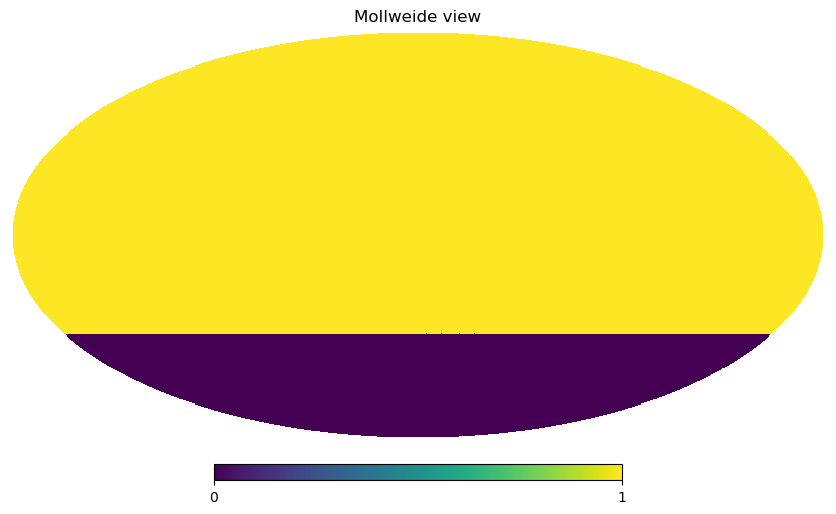

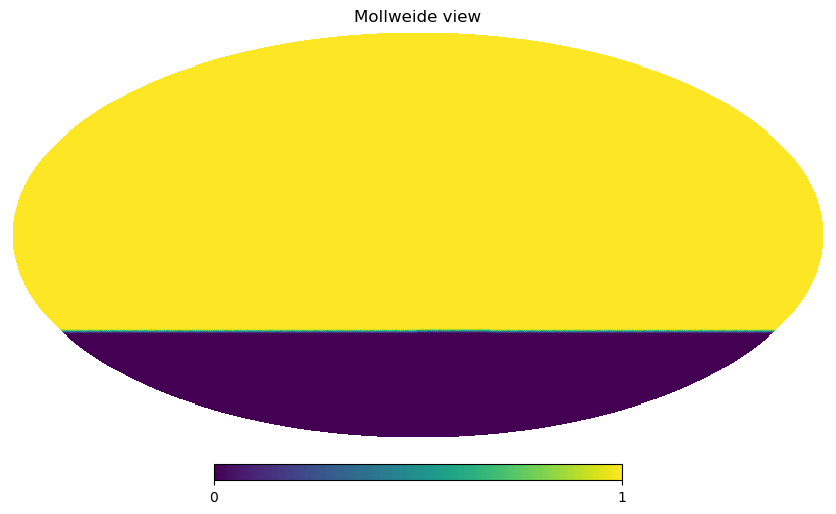

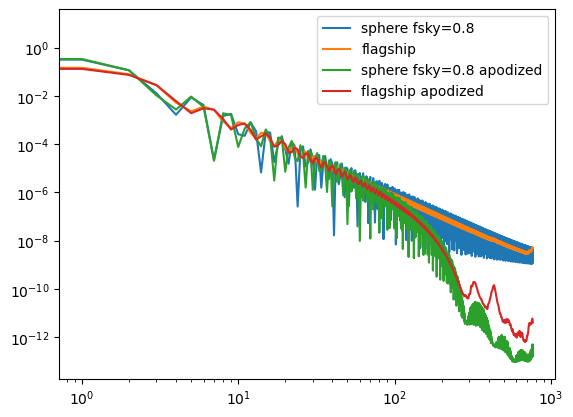

In [70]:
mask_sphere_08 = hp.read_map(data_ref+'mask/circle_fsky0.8_NS256.fits')
mask_sphere_08_C1 = nmt.mask_apodization(mask_sphere_08, 2.5, apotype="C1")
cls_mask_sphere_08 = hp.anafast(mask_sphere_08)
cls_mask_sphere_08_C1 = hp.anafast(mask_sphere_08_C1)

hp.mollview(mask_sphere_08)
hp.mollview(mask_sphere_08_C1)


plt.figure()
plt.loglog(cls_mask_sphere_08, label='sphere fsky=0.8')
plt.loglog(cl_mask_flagship, label='flagship')
plt.loglog(cls_mask_sphere_08_C1, label='sphere fsky=0.8 apodized')
plt.loglog(cl_mask_flagship_C1, label='flagship apodized')
plt.legend()
plt.show()


In [59]:
cov_fs2_full3x2_whitenoise_log_circle08 = np.load(ref_cov+'nmt_test_NS256_circle_fsky0.8_full3x2_logbin.npy')

cu.pos_def(cov_fs2_full3x2_whitenoise_log_circle08, 'FS2, 6 bins White noise Cl, full 3x2, spherical cap fsky = 0.8')


FS2, 6 bins White noise Cl, full 3x2, spherical cap fsky = 0.8  is NOT positive definite


## Look at eigenvalues

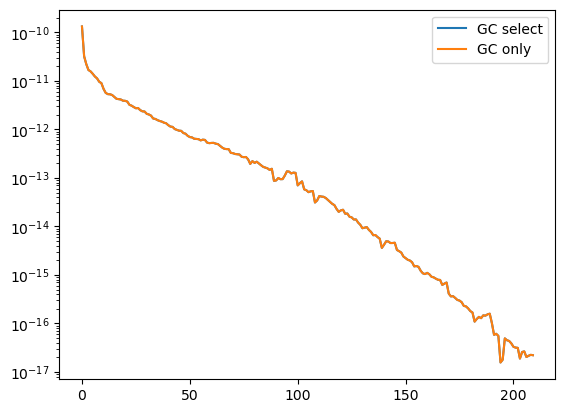

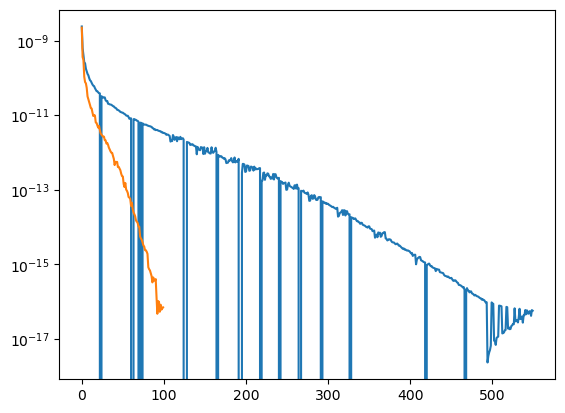

cov_fs2_GC_log  is positive definite


In [41]:
eigv_fs2_GC_log_select = np.linalg.eig(cov_fs2_GC_log_select)[0]
eigv_fs2_GC_log = np.linalg.eig(cov_fs2_GC_log)[0]

eigv_GC_SSCpaper = np.linalg.eig(cov_SSC_paper_GC_re)[0]
eigv_GCauto_SSCpaper = np.linalg.eig(cov_SSC_paper_GCauto_re)[0]


plt.figure()
plt.semilogy(eigv_fs2_GC_log_select, label='GC select')
plt.semilogy(eigv_fs2_GC_log, label='GC only')
plt.legend()
plt.show()



plt.figure()
plt.semilogy(eigv_GC_SSCpaper, label='GC')
plt.semilogy(eigv_GCauto_SSCpaper, label='GC auto')

plt.show()

cu.pos_def(cov_fs2_GC_log, 'cov_fs2_GC_log')

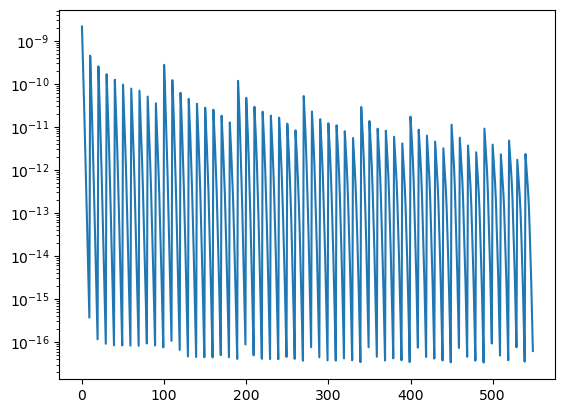

In [24]:
plt.figure()
plt.semilogy(np.diag(cov_SSC_paper_GC_re))
plt.show()